In [1]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import torch.nn.functional as F

fewer_sp500_tickers = [
    "AAPL", "MSFT", "UNH", "LLY", "JPM", "JNJ", "XOM", "WMT", "PG", "CVX",
    "HD", "MRK", "COST", "PEP", "ADBE", "KO", "BAC", "ORCL", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "AMD",
    "NEE", "AMGN", "PM", "HON", "UNP", "UPS", "MS", "LOW", "BA", "IBM",
    "CAT", "MDT", "GS", "GE", "DE", "T", "LRCX", "ADI", "CI", "SYK",
    "MU", "SCHW", "ADP", "MMC", "BDX", "PFE", "ADSK", "SO", "PGR", "TGT",
    "AXP", "AON", "SLB", "CL", "APD", "AEP", "CSX", "F", "GM", "FDX",
    "DG", "NSC", "ITW"
]

sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "NVDA", "META", "TSLA", "BRK-B", "UNH",
    "LLY", "JPM", "V", "JNJ", "XOM", "WMT", "MA", "PG", "AVGO", "CVX", "HD", "MRK",
    "ABBV", "COST", "PEP", "ADBE", "KO", "BAC", "CRM", "ORCL", "TMO", "ACN", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "LIN", "AMD", "NEE",
    "AMGN", "PM", "HON", "UNP", "UPS", "MS", "SPGI", "RTX", "INTU", "LOW", "BA",
    "IBM", "AMT", "CAT", "MDT", "PLD", "GS", "ISRG", "CVS", "NOW", "BLK", "GE",
    "DE", "T", "LRCX", "ADI", "CI", "ZTS", "SYK", "C", "TJX", "MU", "SCHW", "ADP",
    "MMC", "BDX", "MO", "PFE", "BKNG", "CHTR", "CB", "REGN", "MDLZ", "VRTX", "USB",
    "PANW", "GILD", "ELV", "LMT", "ADSK", "SO", "PGR", "TGT", "DUK", "AXP",
    "HCA", "AON", "SLB", "CL", "APD", "EOG", "TJX", "AEP", "CSX", "F", "MAR", "GM",
    "ICE", "FDX", "DG", "MNST", "NSC", "EW", "ITW", "MET", "KHC", "TRV", "PSX", "MPC",
    "COF", "SHW", "OXY", "EMR", "SRE", "ROST", "HUM", "AZO", "CDNS", "KMB", "STZ",
    "ORLY", "ADM", "RMD", "PSA", "BIIB", "IDXX", "VLO", "TT", "CMG", "PRU", "WELL",
    "PCAR", "AFL", "SPG", "CTAS", "HAL", "EXC", "DLR", "AIG", "WMB", "ED", "HPQ",
    "YUM", "CTSH", "PAYX", "AMP", "TEL", "EBAY", "WBD", "OKE", "VICI", "PPG", "FITB",
    "EFX", "D", "DFS", "ALL", "MTB", "KEYS", "ANET", "OTIS", "HES", "BKR", "TTWO",
    "APH", "WEC", "ETN", "ECL", "ROK", "MLM", "AVB", "BAX", "NEM", "XYL", "CMS",
    "DOW", "RSG", "MCK", "GWW", "CHD", "CFG", "FAST", "CAH", "NUE", "VRSK", "LEN",
    "ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", "CAG", "ZBH", "BXP",
    "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"
]

In [2]:
import datetime
import gym
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# ─── 1) PARAMETERS & TICKERS ────────────────────────────────────────────────────

start = datetime.datetime(1990, 1, 1)
end   = datetime.datetime(2025, 4, 29)

# your chosen subset of S&P500 tickers
tickers = fewer_sp500_tickers  # Make sure this is defined

# ─── 2) DOWNLOAD PRICE, VOLUME, DIVIDENDS ─────────────────────────────────────

# 2a) prices & volume
df = yf.download(tickers, start=start, end=end, auto_adjust=False)
prices = df['Close'].ffill().bfill()    # DataFrame (T, N)
vols   = df['Volume'].ffill().bfill()   # DataFrame (T, N)

# 2b) dividends series per ticker (as aligned DataFrames)
divs_dict = {}
for t in tickers:
    divs = yf.Ticker(t).dividends
    divs.index = divs.index.tz_localize(None)  # Make tz-naive
    divs = divs[start:end].astype(np.float32)
    divs_dict[t] = divs
divs_df = pd.DataFrame(divs_dict).reindex(prices.index).ffill().fillna(0.0)

# ─── 3) COMPUTE 30-DAY MA & SLOPE ───────────────────────────────────────────────

ma30 = prices.rolling(window=30).mean().ffill().bfill()  # (T, N)

# slope: linear fit over the last 30 days at each time t
slopes = pd.DataFrame(index=prices.index, columns=prices.columns, dtype=np.float32)
for t in range(len(prices)):
    window = prices.iloc[max(0, t-29):t+1]
    x = np.arange(len(window))
    for col in prices.columns:
        y = window[col].values
        if len(y) >= 2:
            m, _ = np.polyfit(x, y, 1)
        else:
            m = 0.0
        slopes.loc[prices.index[t], col] = np.float32(m)

# convert all to NumPy arrays aligned on the same datetime index
dates       = prices.index
prices_arr  = prices.values.astype(np.float32)     # (T, N)
vols_arr    = vols.values.astype(np.float32)       # (T, N)
divs_arr    = divs_df.values.astype(np.float32)    # (T, N)
ma30_arr    = ma30.values.astype(np.float32)       # (T, N)
slopes_arr  = slopes.values.astype(np.float32)     # (T, N)

# ─── 4) DOWNLOAD MACRO SERIES FROM FRED ────────────────────────────────────────

# UNRATE = unemployment rate (%), DGS10 = 10-yr Treasury yield (%), SP500EARN = S&P500 EPS
macro = pdr.DataReader(
    ['UNRATE','DGS10'], 
    'fred', 
    start, 
    end
).reindex(dates).ffill().bfill()

unemp_arr   = macro['UNRATE'].values.astype(np.float32)    # (T,)
irate_arr   = macro['DGS10'].values.astype(np.float32)     # (T,)


[*********************100%***********************]  71 of 71 completed


In [3]:
print("Splitting data...")
T, N = prices_arr.shape
split_time = int(0.7 * T)  # 70% train, 30% test
val_time = int(0.8 * T)    # 20% validation

# Prevent look-ahead in normalization (using array slicing instead of .iloc)
train_mask = slice(0, split_time)
test_mask = slice(split_time, None)

# Calculate normalization parameters using numpy array slicing
mu_price_train = prices_arr[train_mask].mean(axis=0)
std_price_train = prices_arr[train_mask].std(axis=0) + 1e-6
mu_vol_train = vols_arr[train_mask].mean(axis=0)
std_vol_train = vols_arr[train_mask].std(axis=0) + 1e-6
mu_ma30_train = ma30_arr[train_mask].mean(axis=0)
std_ma30_train = ma30_arr[train_mask].std(axis=0) + 1e-6
mu_slope_train = slopes_arr[train_mask].mean(axis=0)
std_slope_train = slopes_arr[train_mask].std(axis=0) + 1e-6

# Normalize features
def safe_normalize(data, mu, std):
    return (data - mu) / std

features = []
for t in range(T):
    stock_features = np.zeros((N, 7))
    stock_features[:, 0] = safe_normalize(prices_arr[t], mu_price_train, std_price_train)
    stock_features[:, 1] = safe_normalize(vols_arr[t], mu_vol_train, std_vol_train)
    stock_features[:, 2] = divs_arr[t] / (prices_arr[t] + 1e-6)  # Dividend yield
    stock_features[:, 3] = safe_normalize(ma30_arr[t], mu_ma30_train, std_ma30_train)
    stock_features[:, 4] = safe_normalize(slopes_arr[t], mu_slope_train, std_slope_train)
    stock_features[:, 5] = (unemp_arr[t] - unemp_arr.mean()) / (unemp_arr.std() + 1e-6)
    stock_features[:, 6] = (irate_arr[t] - irate_arr.mean()) / (irate_arr.std() + 1e-6)
    features.append(stock_features)

normalized_targets = (prices_arr[1:] - mu_price_train) / (std_price_train + 1e-6)

# Update features and targets
features = np.array(features[:-1])  # Remove last time step to match targets
targets = normalized_targets

Splitting data...


In [4]:
print("Building model...")
class PricePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(7, 1),
        )
    
    def forward(self, x):
        return self.net(x).squeeze()

model = PricePredictor()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.HuberLoss()

# Convert to tensors
X_train = torch.tensor(features[:split_time-1], dtype=torch.float32)
y_train = torch.tensor(targets[:split_time-1], dtype=torch.float32)
X_val = torch.tensor(features[split_time:val_time-1], dtype=torch.float32)
y_val = torch.tensor(targets[split_time:val_time-1], dtype=torch.float32)

Building model...


In [5]:
print("Training model...")
best_val_loss = float('inf')
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    
    # Reshape inputs correctly
    X_train_flat = X_train.reshape(-1, 7)  # (batch*stocks, features)
    y_train_flat = y_train.reshape(-1)     # (batch*stocks)
    
    preds = model(X_train_flat)
    loss = criterion(preds, y_train_flat)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        X_val_flat = X_val.reshape(-1, 7)
        y_val_flat = y_val.reshape(-1)
        val_preds = model(X_val_flat)
        val_loss = criterion(val_preds, y_val_flat)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}: Train Loss {loss.item():.4f}, Val Loss {val_loss.item():.4f}")

Training model...
Epoch 100: Train Loss 0.5340, Val Loss 2.8092
Epoch 200: Train Loss 0.3567, Val Loss 2.2243
Epoch 300: Train Loss 0.2310, Val Loss 1.6216
Epoch 400: Train Loss 0.1436, Val Loss 1.0944
Epoch 500: Train Loss 0.0902, Val Loss 0.6994
Epoch 600: Train Loss 0.0607, Val Loss 0.4389
Epoch 700: Train Loss 0.0445, Val Loss 0.2831
Epoch 800: Train Loss 0.0343, Val Loss 0.1919
Epoch 900: Train Loss 0.0268, Val Loss 0.1362
Epoch 1000: Train Loss 0.0209, Val Loss 0.0995
Epoch 1100: Train Loss 0.0161, Val Loss 0.0737
Epoch 1200: Train Loss 0.0123, Val Loss 0.0547
Epoch 1300: Train Loss 0.0093, Val Loss 0.0405
Epoch 1400: Train Loss 0.0070, Val Loss 0.0299
Epoch 1500: Train Loss 0.0053, Val Loss 0.0220
Epoch 1600: Train Loss 0.0041, Val Loss 0.0164
Epoch 1700: Train Loss 0.0032, Val Loss 0.0124
Epoch 1800: Train Loss 0.0026, Val Loss 0.0096
Epoch 1900: Train Loss 0.0021, Val Loss 0.0078
Epoch 2000: Train Loss 0.0019, Val Loss 0.0065


In [6]:
# Load best model
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

# Get test data (updated)
test_start = val_time
X_test = torch.tensor(features[test_start:-1], dtype=torch.float32)  # Test features
y_test = targets[test_start:-1]  # Adjusted to match X_test length

# Generate predictions
with torch.no_grad():
    test_preds_normalized = model(X_test.reshape(-1, 7)).numpy()

# Denormalize
test_preds = test_preds_normalized.reshape(-1, len(tickers)) * std_price_train + mu_price_train
true_prices = y_test.reshape(-1, len(tickers)) * std_price_train + mu_price_train  # Now same shape as test_preds

# Calculate MSE (no more shape error)
mse_per_stock = np.mean((test_preds - true_prices) ** 2, axis=0)
overall_mse = np.mean((test_preds - true_prices) ** 2)

print(f"\nTest Set MSE Results:")
print(f"Overall MSE: ${overall_mse:.2f}")
print(f"Best Stock MSE: ${np.min(mse_per_stock):.2f} ({tickers[np.argmin(mse_per_stock)]})")
print(f"Worst Stock MSE: ${np.max(mse_per_stock):.2f} ({tickers[np.argmax(mse_per_stock)]})")
print(f"Average Stock MSE: ${np.mean(mse_per_stock):.2f}")


Test Set MSE Results:
Overall MSE: $48.67
Best Stock MSE: $0.33 (APD)
Worst Stock MSE: $371.96 (CAT)
Average Stock MSE: $48.67


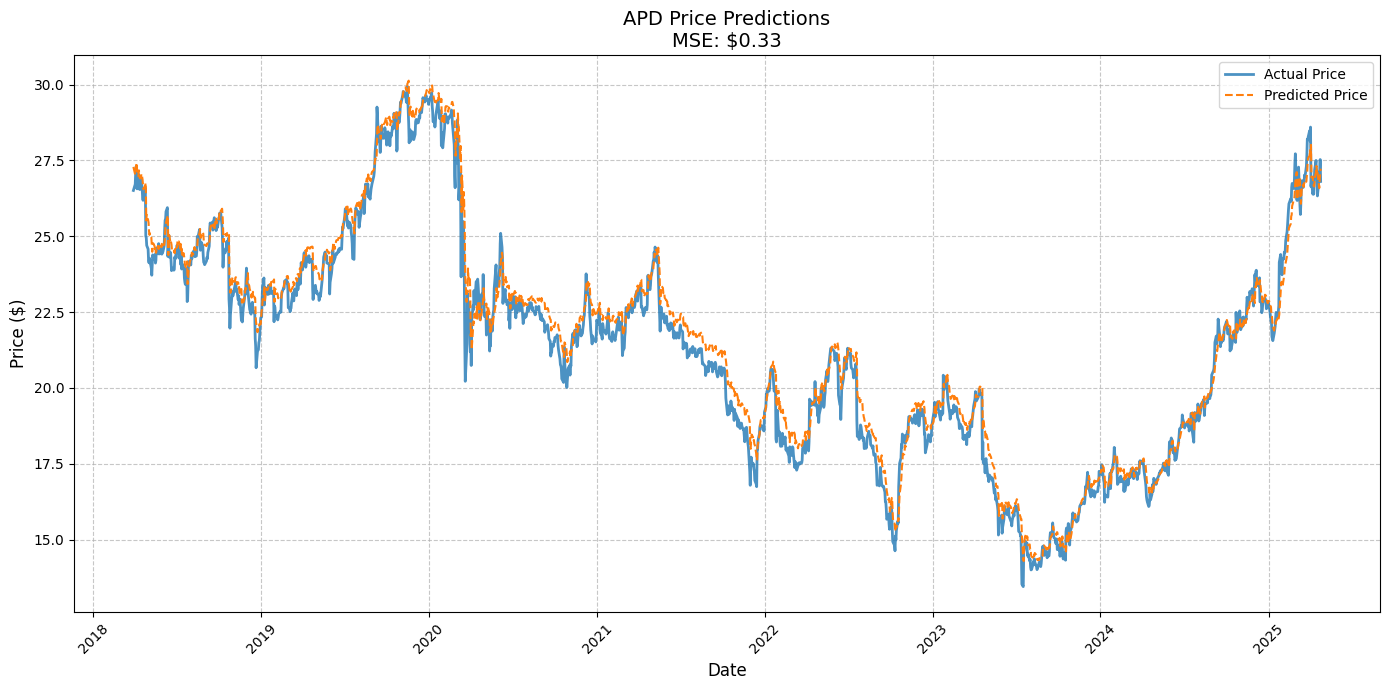

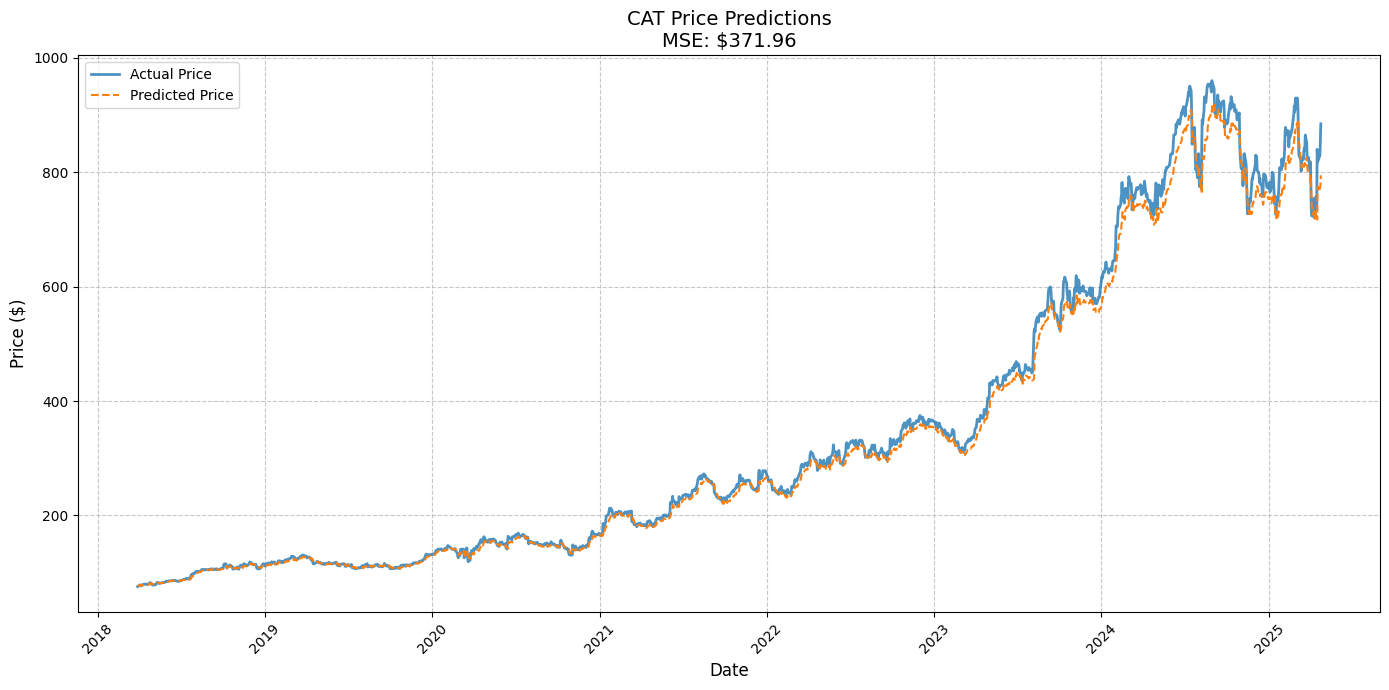

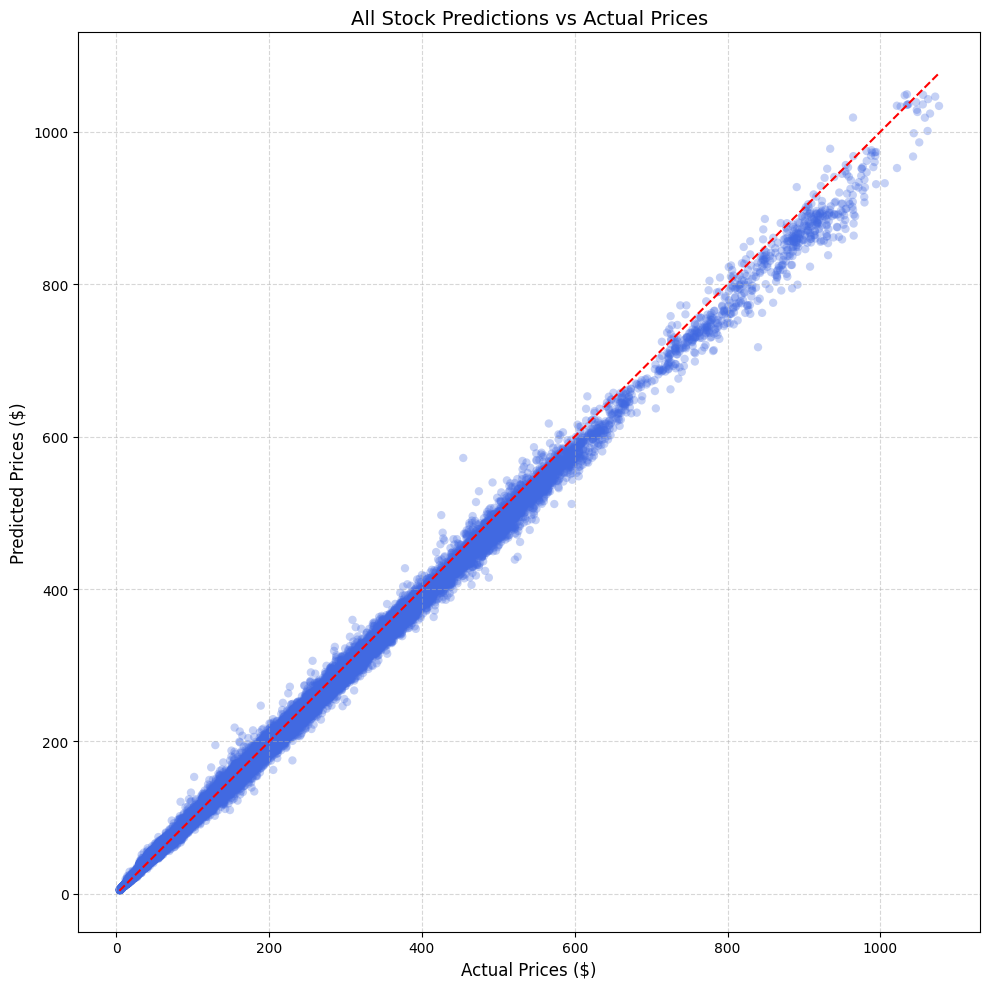

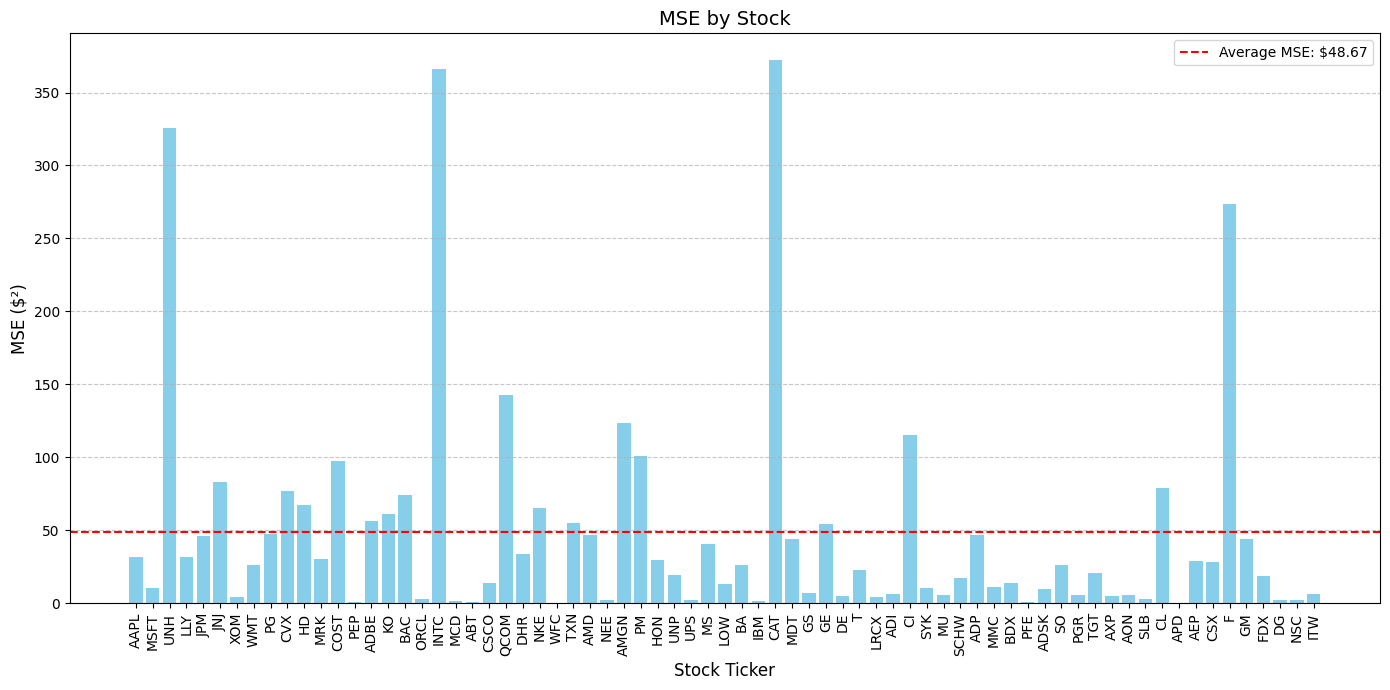

In [7]:
import matplotlib.pyplot as plt

# Get test dates
test_dates = dates[test_start:test_start + len(test_preds)]

# 1. Plot Time Series for a Sample Stock
def plot_stock_predictions(stock_idx, stock_name):
    plt.figure(figsize=(14, 7))
    
    # Actual prices
    plt.plot(test_dates, true_prices[:, stock_idx], 
             label='Actual Price', linewidth=2, alpha=0.8)
    
    # Predicted prices
    plt.plot(test_dates, test_preds[:, stock_idx], 
             label='Predicted Price', linestyle='--', linewidth=1.5)
    
    plt.title(f'{stock_name} Price Predictions\nMSE: ${mse_per_stock[stock_idx]:.2f}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot best and worst performing stocks
plot_stock_predictions(np.argmin(mse_per_stock), tickers[np.argmin(mse_per_stock)])  # WFC
plot_stock_predictions(np.argmax(mse_per_stock), tickers[np.argmax(mse_per_stock)])  # UNH

# 2. Scatter Plot of All Predictions vs Actuals
plt.figure(figsize=(10, 10))
plt.scatter(true_prices.flatten(), test_preds.flatten(), 
            alpha=0.3, c='royalblue', edgecolors='none')
plt.plot([true_prices.min(), true_prices.max()], 
         [true_prices.min(), true_prices.max()], 'r--')

plt.title('All Stock Predictions vs Actual Prices', fontsize=14)
plt.xlabel('Actual Prices ($)', fontsize=12)
plt.ylabel('Predicted Prices ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Error Distribution Plot
plt.figure(figsize=(14, 7))
plt.bar(tickers, mse_per_stock, color='skyblue')
plt.axhline(overall_mse, color='red', linestyle='--', 
            label=f'Average MSE: ${overall_mse:.2f}')
plt.title('MSE by Stock', fontsize=14)
plt.xlabel('Stock Ticker', fontsize=12)
plt.ylabel('MSE ($²)', fontsize=12)
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
# Step 1: Calculate predicted and true price changes
preds_change = test_preds[1:] - test_preds[:-1]
true_change = true_prices[1:] - true_prices[:-1]

# Step 2: Compute hit matrix (True where sign is correct)
hit_matrix = (preds_change * true_change) > 0

# Step 3: Hit rate per stock and overall
hit_rate_per_stock = np.mean(hit_matrix, axis=0)
overall_hit_rate = np.mean(hit_matrix)

print(f"\nDirectional Accuracy (Hit Rate):")
print(f"Overall Hit Rate: {overall_hit_rate:.2%}")
print(f"Best Stock Hit Rate: {np.max(hit_rate_per_stock):.2%} ({tickers[np.argmax(hit_rate_per_stock)]})")
print(f"Worst Stock Hit Rate: {np.min(hit_rate_per_stock):.2%} ({tickers[np.argmin(hit_rate_per_stock)]})")
print(f"Average Stock Hit Rate: {np.mean(hit_rate_per_stock):.2%}")


Directional Accuracy (Hit Rate):
Overall Hit Rate: 49.60%
Best Stock Hit Rate: 52.73% (INTC)
Worst Stock Hit Rate: 44.12% (CSX)
Average Stock Hit Rate: 49.60%


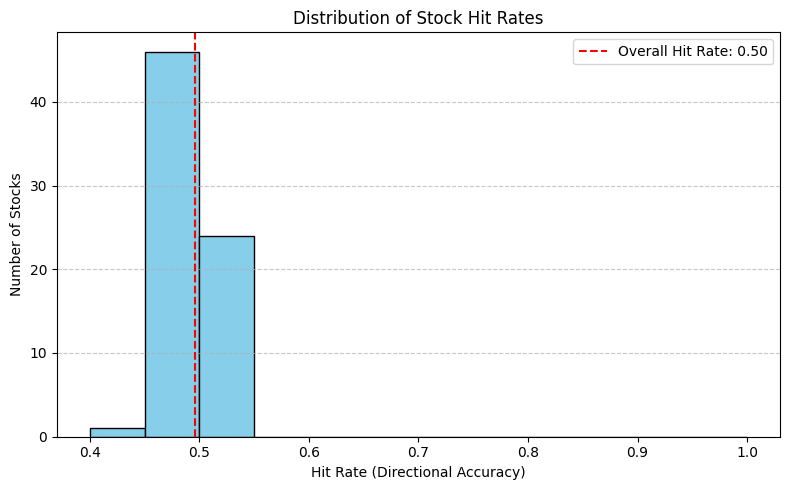

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Histogram bins (adjust as needed)
bins = np.arange(0.4, 1.05, 0.05)  # from 40% to 100% in 5% steps

plt.figure(figsize=(8, 5))
plt.hist(hit_rate_per_stock, bins=bins, color='skyblue', edgecolor='black')
plt.axvline(overall_hit_rate, color='red', linestyle='--', label=f'Overall Hit Rate: {overall_hit_rate:.2f}')

plt.xlabel('Hit Rate (Directional Accuracy)')
plt.ylabel('Number of Stocks')
plt.title('Distribution of Stock Hit Rates')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
